<a href="https://colab.research.google.com/github/89CANDY89/BOOTCAMP-2-ALURA/blob/main/MODULO3/PROJETO_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NÚMEROS DA COVID 19 NO ESTADO DO RIO DE JANEIRO

Sobre este Estudo
Este notebook tem como premissa demonstrar o meu desenvolvimento na área de Ciência de Dados, utilizando técnicas aprendidas no Bootcamp Data Science Aplicada da Alura.

Serão extraídos os dados da COVID 19 referente ao estado do Rio de janeiro

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import warnings
warnings.simplefilter(action='ignore')

from functools import reduce
from pandas.plotting import autocorrelation_plot
from fbprophet.diagnostics import cross_validation
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_plotly, plot_components_plotly


mpl.rcParams['figure.figsize'] = (16,10)
sns.set_style("white")

In [ ]:
dados = pd.read_csv('https://github.com/marcelobin/BootCamp-Data-Science---Alura/blob/main/Projeto%20-%20M%C3%B3dulo%203%20-%20S%C3%A9ries%20Temporais/dados/caso_full.zip?raw=true',
                              sep = ',', compression='zip')

In [ ]:
dados.isna().sum()

city                                             12559
city_ibge_code                                    8326
date                                                 0
epidemiological_week                                 0
estimated_population                              8326
estimated_population_2019                         8326
is_last                                              0
is_repeated                                          0
last_available_confirmed                             0
last_available_confirmed_per_100k_inhabitants    23845
last_available_date                                  0
last_available_death_rate                            0
last_available_deaths                                0
order_for_place                                      0
place_type                                           0
state                                                0
new_confirmed                                        0
new_deaths                                           0
dtype: int

In [ ]:
regioes_dic = {
            'Norte' : ['RO','AC','AM','RR','PA','AP','TO' ],
            'Nordeste': ['MA','PI','CE','RN','PB','PE','AL','SE','BA'],
            'Sudeste' : ['MG','ES','RJ','SP'],
            'Sul' : ['PR','SC','RS'],
            'Centro-Oeste' : ['MS','MT','GO','DF']
           }

regioes = []
for estado in dados['state']:
  for regiao, uf in regioes_dic.items():
    if estado in uf:
      regioes.append(regiao)
   
dados['regiao'] = regiao
dados['date'] = pd.to_datetime(dados['date'], format ='%Y-%m-%d')

In [ ]:
dados_br = dados[['date','epidemiological_week', 'regiao','state','city','estimated_population',
                  'place_type','new_confirmed','new_deaths']]
dados_br.columns=['data','semana_epidemiologica','regiao','uf','cidade','populacao_estimada',
                  'tipo_local', 'casos_novos', 'obitos_novos']
dados_br.head()

,data,semana_epidemiologica,regiao,uf,cidade,populacao_estimada,tipo_local,casos_novos,obitos_novos
0,2020-03-17,202012,Centro-Oeste,AC,Rio Branco,413418.0,city,3,0
1,2020-03-17,202012,Centro-Oeste,AC,NaN,894470.0,state,3,0
2,2020-03-18,202012,Centro-Oeste,AC,Rio Branco,413418.0,city,0,0
3,2020-03-18,202012,Centro-Oeste,AC,NaN,894470.0,state,0,0
4,2020-03-19,202012,Centro-Oeste,AC,Rio Branco,413418.0,city,1,0


In [ ]:
dados_ms = dados_br.query('uf =="RJ" and tipo_local =="state"')
dados_ms['casos_acumulados'] = dados_ms['casos_novos'].cumsum()
dados_ms['media_movel_casos'] = dados_ms['casos_novos'].rolling(window=14).mean()
dados_ms['obitos_acumulados'] = dados_ms['obitos_novos'].cumsum()
dados_ms['media_movel_obitos'] = dados_ms['obitos_novos'].rolling(window=14).mean()
dados_ms['obitosNovos7'] = dados_ms['obitos_novos'].shift(-7)
dados_ms['obitosNovos14'] = dados_ms['obitos_novos'].shift(-14)
dados_ms['obitosNovos21'] = dados_ms['obitos_novos'].shift(-21)
dados_ms['obitosNovos30'] = dados_ms['obitos_novos'].shift(-30)

dados_ms['ano'] = pd.DatetimeIndex(dados_ms.data).year
dados_ms['mes'] = pd.DatetimeIndex(dados_ms.data).month

Criando Funções de Plot

In [ ]:
def plotar_linha(x, y, df, titulo, ylabel, xlabel, label, yscale='linear'):
  plt.figure(figsize=(18,8))
  sns.lineplot(x=x, y=y, data=df, label=label.title(), linewidth=2)
  sns.despine(bottom=True, left=True)
  plt.yscale(yscale)
  plt.title(titulo.title(), fontsize=16, weight='bold', pad=20, loc='left')
  plt.ylabel(ylabel.title(), fontsize=14, weight='semibold')
  plt.xlabel(xlabel.title(), fontsize=14, weight='semibold')
  plt.legend(fontsize=14)
  plt.grid(alpha=.2)

RIO DE JANEIRO

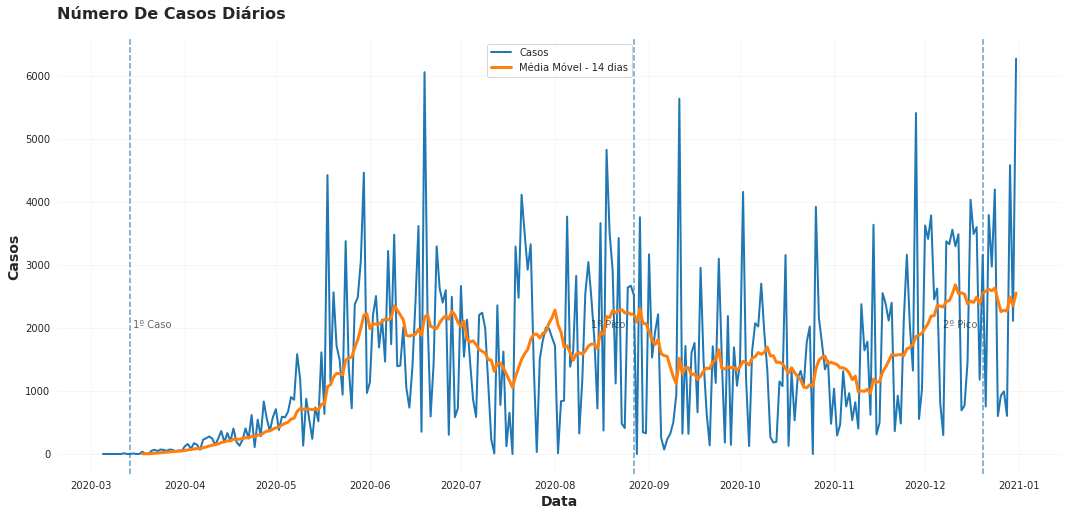

In [ ]:
dados_ms_2020 = dados_ms.query('data < 2021')

plotar_linha(x='data',y='casos_novos',df=dados_ms_2020, titulo='Número de Casos Diários',
             ylabel='casos',xlabel='Data',label='casos')
ax = sns.lineplot(x='data', y='media_movel_casos', data=dados_ms_2020, label='Média Móvel - 14 dias', linewidth=3)
ax.axvline(x=dt.datetime(2020, 3, 14), linestyle='dashed', alpha=0.7)
ax.text(x=dt.datetime(2020, 3, 15), y=2010, s='1º Caso', alpha=0.7)
plt.axvline(dt.datetime(2020,8,27),ymin=0, ymax=1,linestyle='dashed',alpha=0.7)
plt.text(x=dt.datetime(2020, 8, 13), y=2010, s='1º Pico', alpha=0.7)
plt.axvline(dt.datetime(2020,12,20),ymin=0, ymax=1,linestyle='dashed',alpha=0.7)
plt.text(x=dt.datetime(2020, 12, 7), y=2010, s='2º Pico', alpha=0.7)
plt.show()

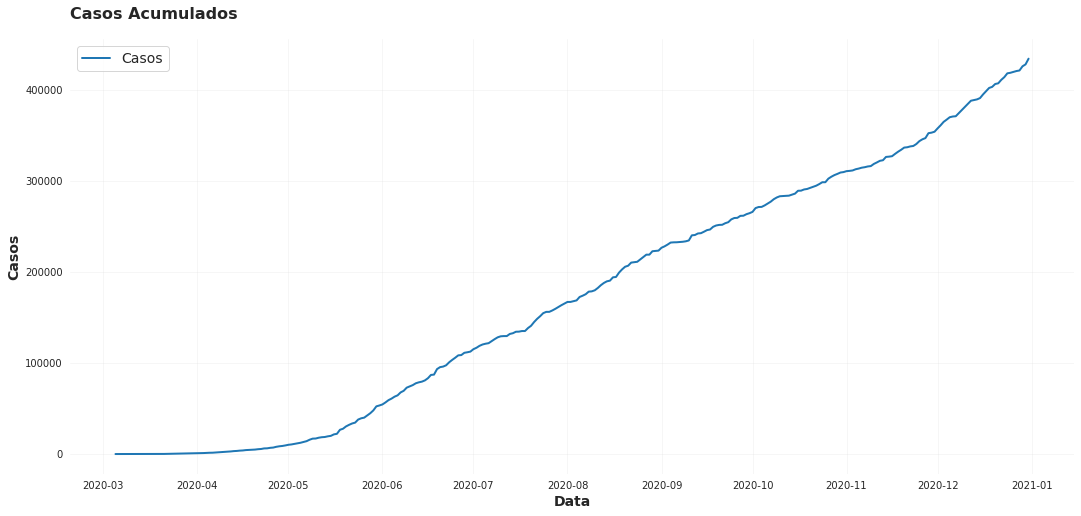

In [ ]:
plotar_linha('data','casos_acumulados',dados_ms_2020, 'casos acumulados','casos', 'data', 'casos')

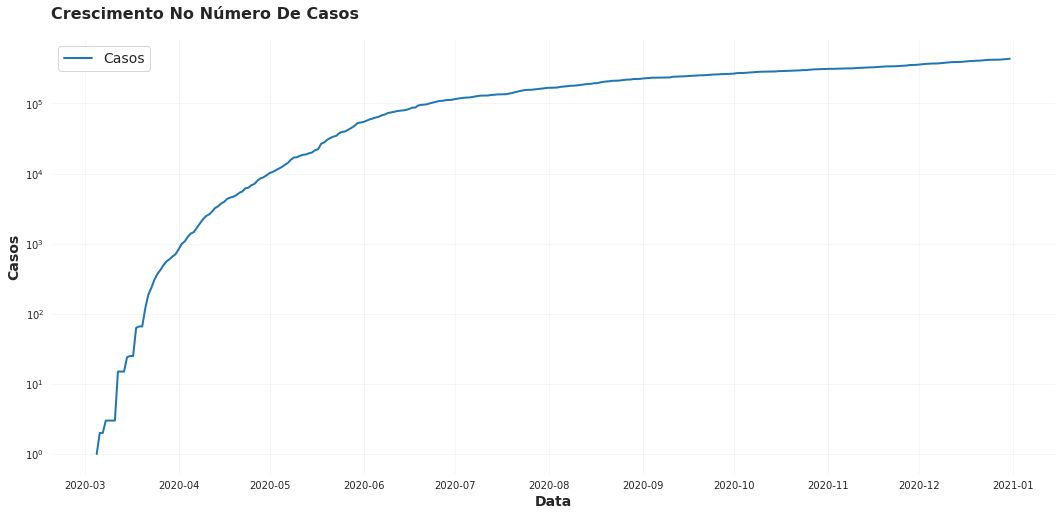

In [ ]:
plotar_linha('data','casos_acumulados',dados_ms_2020,'crescimento no número de casos','casos','data','casos','log')

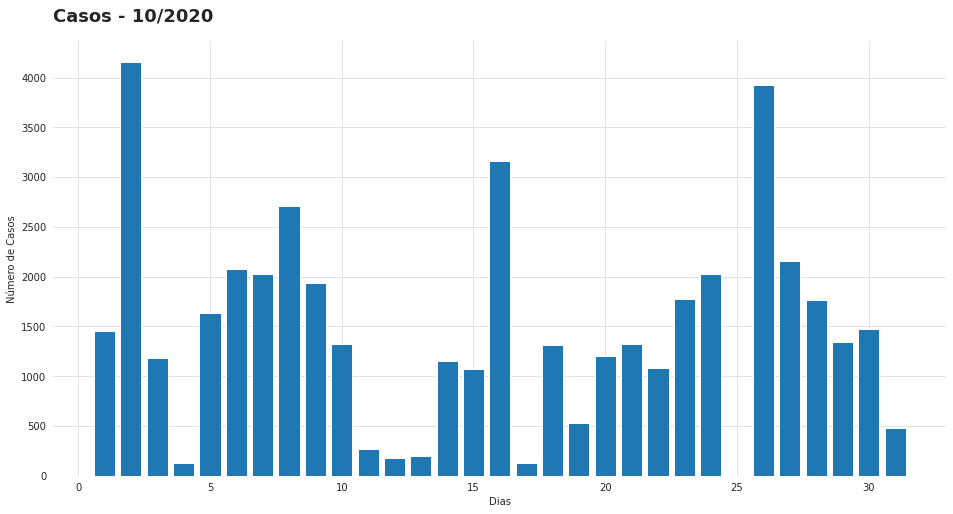

In [ ]:
dados_ms_202010 = dados_ms_2020.query('mes == 10')

plt.figure(figsize=(16,8))
plt.bar(np.linspace(1,31,31), dados_ms_202010['casos_novos'])
plt.title('Casos - 10/2020', fontsize=18, loc='left', weight='bold', pad=20)
plt.xlabel('Dias')
plt.ylabel('Número de Casos')
sns.despine(bottom=True, left=True)
plt.grid(alpha=.7)
plt.show()

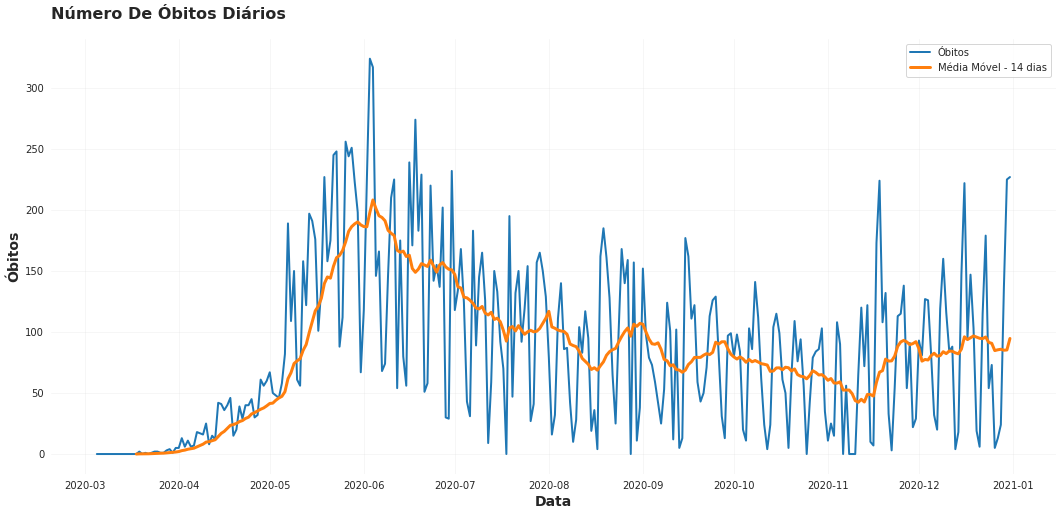

In [ ]:
plotar_linha(x='data',y='obitos_novos',df=dados_ms_2020, titulo='Número de Óbitos Diários',
             ylabel='óbitos',xlabel='Data',label='óbitos')
ax = sns.lineplot(x='data', y='media_movel_obitos', data=dados_ms_2020, label='Média Móvel - 14 dias', linewidth=3)

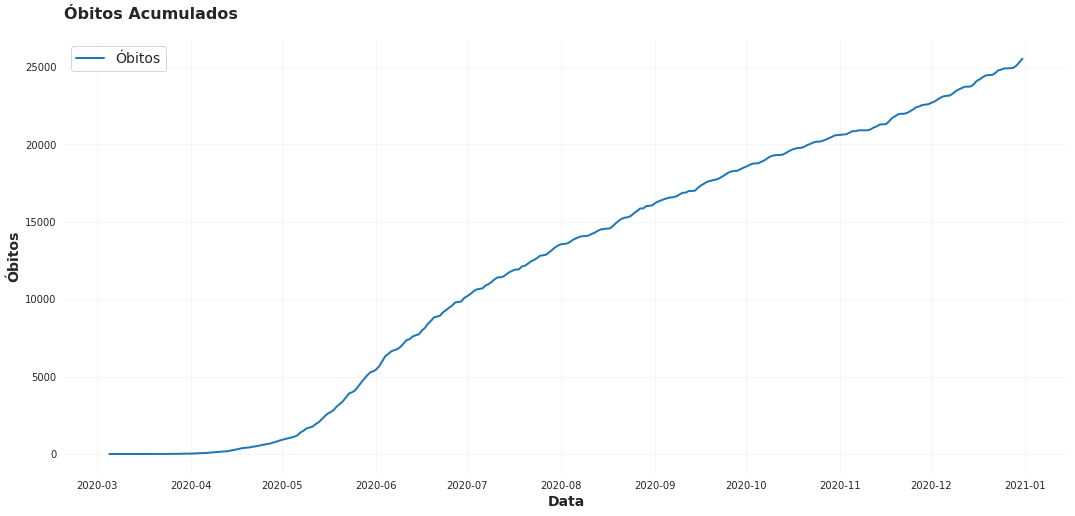

In [ ]:
plotar_linha(x='data',y='obitos_acumulados',df=dados_ms_2020, titulo='Óbitos Acumulados',
             ylabel='óbitos',xlabel='Data',label='óbitos')

Correlação Entre Casos e Óbitos

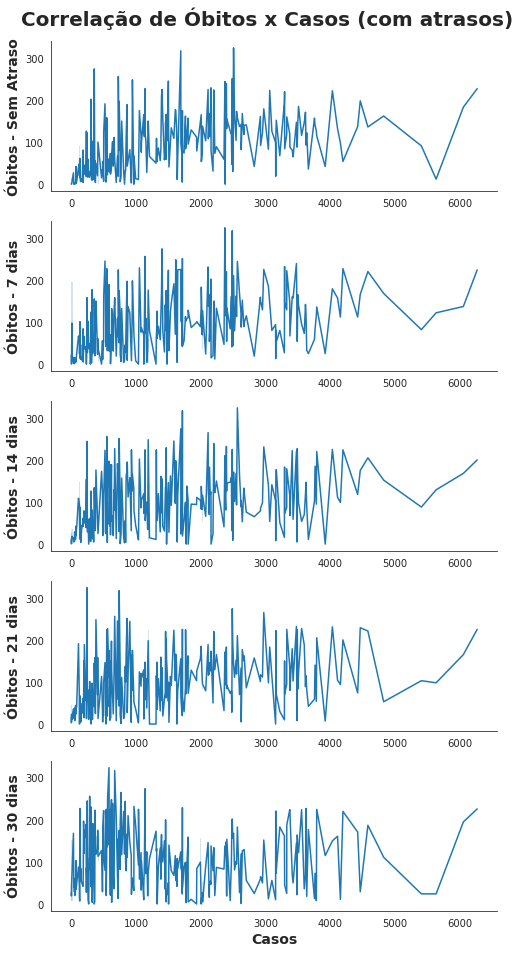

In [ ]:
plt.figure(figsize=(8,16))
plt.subplots_adjust(hspace=.2)
plt.suptitle('Correlação de Óbitos x Casos (com atrasos)', weight='black', fontsize=20, y=0.91)

plt.subplot(5,1,1)
sns.lineplot(y='obitos_novos', x = 'casos_novos', data=dados_ms_2020)
sns.despine()
plt.ylabel('Óbitos - Sem Atraso', fontsize=14, weight='bold')
plt.xlabel('', fontsize=14, weight='bold')

plt.subplot(5,1,2)
sns.lineplot(y='obitosNovos7',x='casos_novos', data=dados_ms_2020)
sns.despine()
plt.ylabel('Óbitos - 7 dias', fontsize=14, weight='bold')
plt.xlabel('', fontsize=14, weight='bold')

plt.subplot(5,1,3)
sns.lineplot(y='obitosNovos14',x='casos_novos', data=dados_ms_2020)
sns.despine()
plt.ylabel('Óbitos - 14 dias', fontsize=14, weight='bold')
plt.xlabel('', fontsize=14, weight='bold')

plt.subplot(5,1,4)
sns.lineplot(y='obitosNovos21',x='casos_novos', data=dados_ms_2020)
sns.despine()
plt.ylabel('Óbitos - 21 dias', fontsize=14, weight='bold')
plt.xlabel('', fontsize=14, weight='bold')

plt.subplot(5,1,5)
sns.lineplot(y='obitosNovos30',x='casos_novos', data=dados_ms_2020)
sns.despine()
plt.ylabel('Óbitos - 30 dias', fontsize=14, weight='bold')
plt.xlabel('Casos', fontsize=14, weight='bold')

plt.show()

In [ ]:

#Visualizando a correlação entre os dados de Casos e Óbitos
dados_corr = dados_ms_2020[['casos_novos','obitos_novos','obitosNovos7','obitosNovos14','obitosNovos21','obitosNovos30']].corr()
dados_corr

,casos_novos,obitos_novos,obitosNovos7,obitosNovos14,obitosNovos21,obitosNovos30
casos_novos,1.000000,0.522577,0.451631,0.386763,0.363277,0.061762
obitos_novos,0.522577,1.000000,0.749931,0.649009,0.583176,0.060470
obitosNovos7,0.451631,0.749931,1.000000,0.734880,0.642362,0.123168
obitosNovos14,0.386763,0.649009,0.734880,1.000000,0.733955,0.178237
obitosNovos21,0.363277,0.583176,0.642362,0.733955,1.000000,0.213493
obitosNovos30,0.061762,0.060470,0.123168,0.178237,0.213493,1.000000


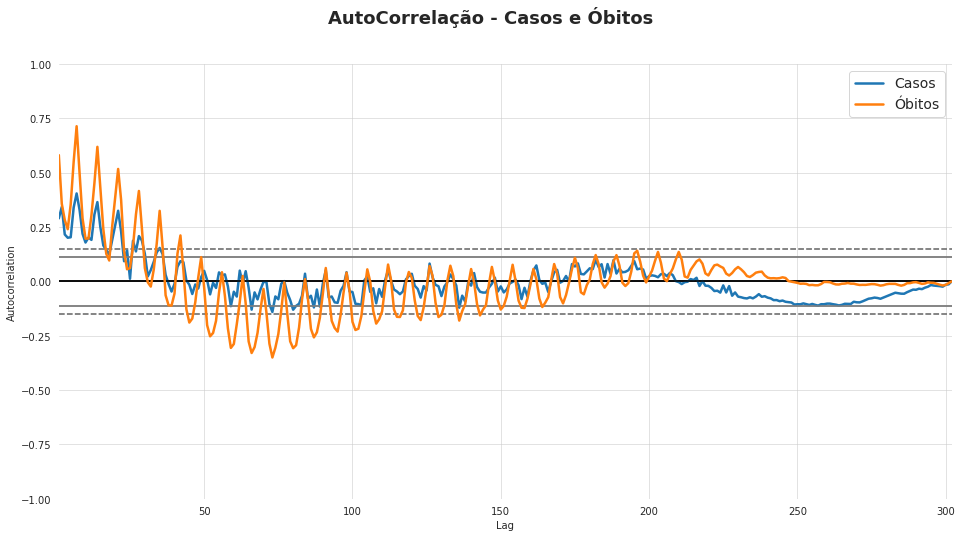

In [ ]:
#Plotando autocorrelação - Casos e Óbitos
plt.figure(figsize=(16,8))
plt.suptitle('AutoCorrelação - Casos e Óbitos', fontsize=18, weight='bold')
autocorrelation_plot(dados_ms_2020['casos_novos'], linewidth=2.5, label='Casos')
autocorrelation_plot(dados_ms_2020['obitos_novos'], linewidth=2.5, label='Óbitos')
plt.legend(fontsize=14)
plt.grid(alpha=.7)
sns.despine(bottom=True, left=True)
plt.show()

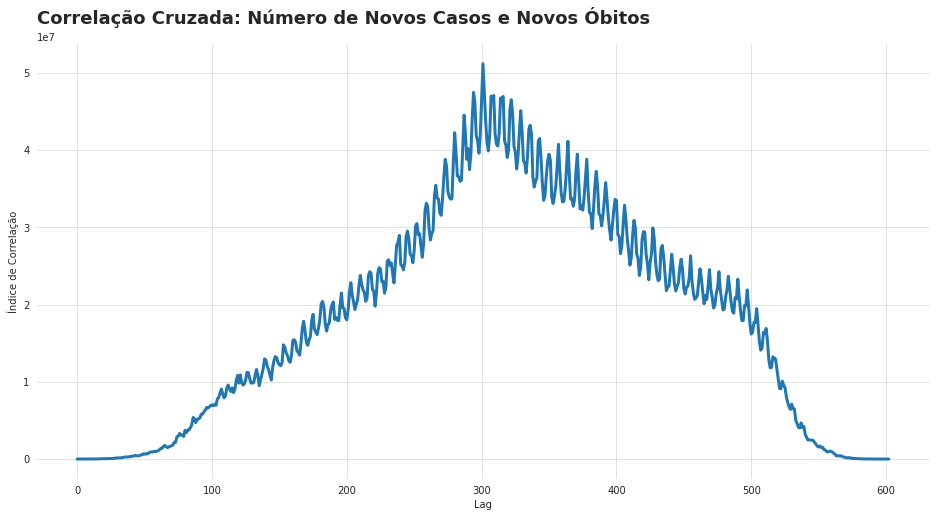

In [ ]:
#Correlação Cruzada - Óbitos e Casos
plt.figure(figsize=(16,8))
plt.plot(np.correlate(dados_ms_2020['casos_novos'], dados_ms_2020['obitos_novos'], "full"), linewidth=3)
plt.ylabel('Índice de Correlação')
plt.xlabel('Lag')
plt.title('Correlação Cruzada: Número de Novos Casos e Novos Óbitos', fontsize=18, fontweight='bold', pad=20, loc='left')
sns.despine(bottom=True, left=True)
plt.grid(alpha=.7)
plt.show()

In [ ]:
dados_ms_2021 = dados_ms.query('ano == 2021')

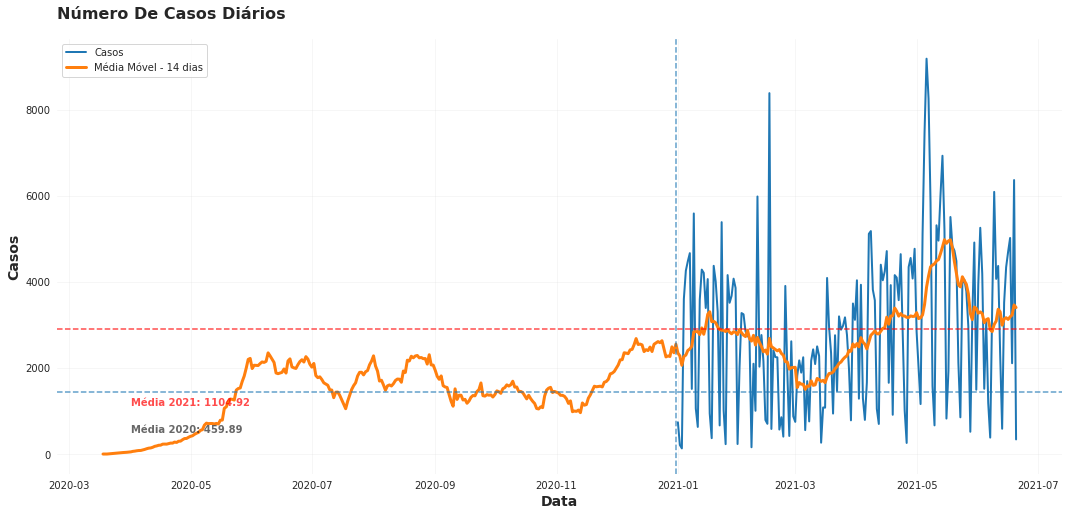

In [ ]:
plotar_linha(x='data',y='casos_novos',df=dados_ms_2021, titulo='Número de Casos Diários',
             ylabel='casos',xlabel='Data',label='casos')
ax = sns.lineplot(x='data', y='media_movel_casos', data=dados_ms, label='Média Móvel - 14 dias', linewidth=3)
ax.axvline(x=dt.datetime(2020, 12, 31), linestyle='dashed', alpha=0.7)
plt.axhline(y=dados_ms_2020['casos_novos'].mean(), linestyle='dashed', alpha=0.7)
plt.text(x=dt.datetime(2020, 4, 1), y=500, s='Média 2020: 459.89', alpha=0.7,weight='semibold')
plt.axhline(y=dados_ms_2021['casos_novos'].mean(), linestyle='dashed', alpha=0.7, color='red')
plt.text(x=dt.datetime(2020, 4, 1), y=1120, s='Média 2021: 1104.92', alpha=0.7, color='red', weight='semibold')
plt.show()

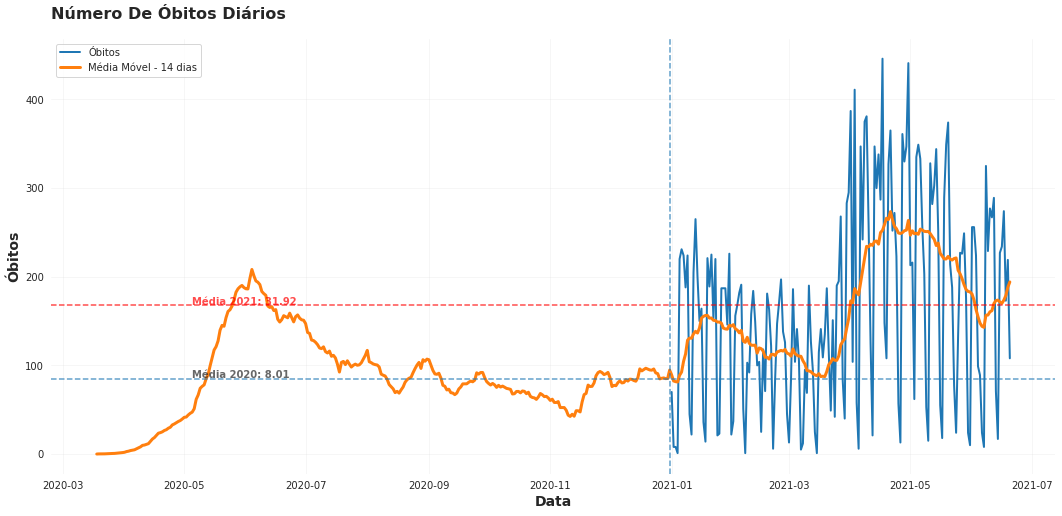

In [ ]:
plotar_linha(x='data',y='obitos_novos',df=dados_ms_2021, titulo='Número de Óbitos Diários',
             ylabel='óbitos',xlabel='Data',label='Óbitos')
ax = sns.lineplot(x='data', y='media_movel_obitos', data=dados_ms, label='Média Móvel - 14 dias', linewidth=3)
ax.axvline(x=dt.datetime(2020, 12, 31), linestyle='dashed', alpha=0.7)
plt.axhline(y=dados_ms_2020['obitos_novos'].mean(), linestyle='dashed', alpha=0.7)
plt.text(x=dt.datetime(2020, 5, 5), y=dados_ms_2020['obitos_novos'].mean()+1, s='Média 2020: 8.01', alpha=0.7,weight='semibold')
plt.axhline(y=dados_ms_2021['obitos_novos'].mean(), linestyle='dashed', alpha=0.7, color='red')
plt.text(x=dt.datetime(2020, 5, 5), y=dados_ms_2021['obitos_novos'].mean()+1, s='Média 2021: 31.92', alpha=0.7, color='red', weight='semibold')
plt.show()

In [ ]:
dados_corr = dados_ms_2021[['casos_novos','obitos_novos','obitosNovos7','obitosNovos14','obitosNovos21','obitosNovos30']].corr()
dados_corr

,casos_novos,obitos_novos,obitosNovos7,obitosNovos14,obitosNovos21,obitosNovos30
casos_novos,1.000000,0.664121,0.562879,0.510952,0.410453,-0.137327
obitos_novos,0.664121,1.000000,0.739587,0.736309,0.630165,-0.125249
obitosNovos7,0.562879,0.739587,1.000000,0.745466,0.734463,-0.065993
obitosNovos14,0.510952,0.736309,0.745466,1.000000,0.741965,-0.022710
obitosNovos21,0.410453,0.630165,0.734463,0.741965,1.000000,0.090489
obitosNovos30,-0.137327,-0.125249,-0.065993,-0.022710,0.090489,1.000000


PROJEÇÕES

In [ ]:
df = dados_ms[['data','casos_novos']]
df.columns = ['ds','y']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473 entries, 1467332 to 1508462
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      473 non-null    datetime64[ns]
 1   y       473 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.1 KB


In [ ]:
modelo = Prophet(n_changepoints = 10, changepoint_prior_scale=10.0, seasonality_mode='multiplicative')
modelo.fit(df)
futuro = modelo.make_future_dataframe(periods=60, freq='D')
previsao = modelo.predict(futuro)
previsao.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-03-05,21.588868,-1421.611674,1522.065109,21.588868,21.588868,0.290645,0.290645,0.290645,0.290645,0.290645,0.290645,0.0,0.0,0.0,27.863572
1,2020-03-06,21.683286,-1451.380828,1464.014049,21.683286,21.683286,0.086839,0.086839,0.086839,0.086839,0.086839,0.086839,0.0,0.0,0.0,23.566236
2,2020-03-07,21.777704,-1469.180919,1497.443059,21.777704,21.777704,0.016480,0.016480,0.016480,0.016480,0.016480,0.016480,0.0,0.0,0.0,22.136602
3,2020-03-08,21.872122,-1468.872617,1418.262634,21.872122,21.872122,-0.508651,-0.508651,-0.508651,-0.508651,-0.508651,-0.508651,0.0,0.0,0.0,10.746852
4,2020-03-09,21.966540,-1525.412072,1506.700038,21.966540,21.966540,-0.510353,-0.510353,-0.510353,-0.510353,-0.510353,-0.510353,0.0,0.0,0.0,10.755849


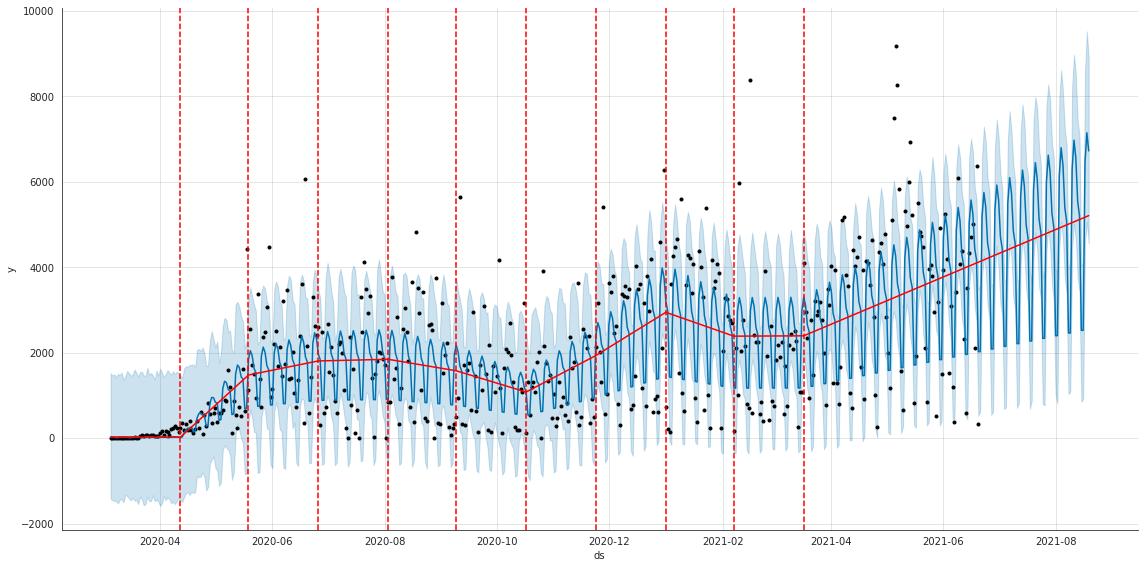

In [ ]:
fig=modelo.plot(previsao, uncertainty=True, figsize=(16,8));
a=add_changepoints_to_plot(fig.gca(),modelo,previsao,cp_color='r')

sns.despine()
plt.show()

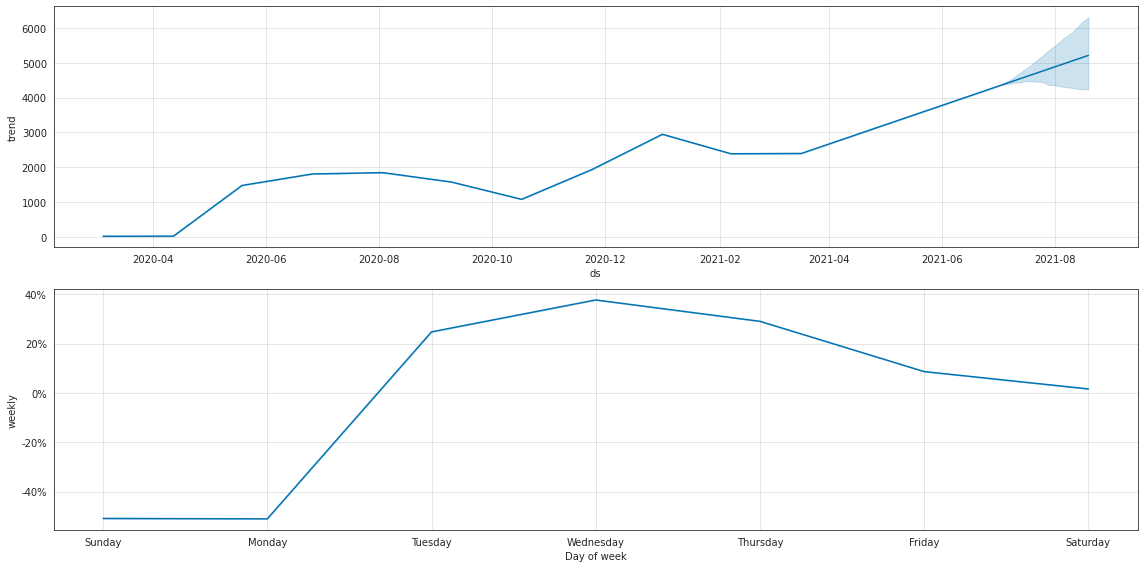

In [ ]:
modelo.plot_components(previsao, figsize=(16,8));
plt.show()

In [ ]:
novo_y = df.reset_index()

NameError: ignored

In [ ]:
df_ajustado = novo_y[(novo_y['y'] > previsao['yhat_lower'][:464]) & (novo_y['y'] < previsao['yhat_lower'][:464])]

ValueError: ignored

In [ ]:
df_ajustado.head()

NameError: ignored

In [ ]:
modelo2 = Prophet(n_changepoints = 10, changepoint_prior_scale=10.0, seasonality_mode='multiplicative')
modelo2.fit(df_ajustado)
futuro2 = modelo2.make_future_dataframe(periods=60, freq='D')
previsao2 = modelo2.predict(futuro2)

fig=modelo2.plot(previsao2, uncertainty=True, figsize=(16,8));
a=add_changepoints_to_plot(fig.gca(),modelo2,previsao2,cp_color='r')

sns.despine()
plt.show()

NameError: ignored

In [ ]:
df_cv = cross_validation(modelo2, initial = "360 days", horizon='30 days', 
                         period='30 days')

AttributeError: ignored